In [1]:
import spacy
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, Nmf
from gensim.utils import simple_preprocess
import zipfile
import pickle
from tensorflow import keras
from keras.models import load_model
import numpy as np
import re
from tensorflow.keras import layers
from nltk.corpus import stopwords
import nltk
import tqdm
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import copy

# WIP code part
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# nltk.download('en_core_web_sm')
# nltk.download('stopwords')

# load the pre-trained English language model
nlp = spacy.load('en_core_web_sm')

custom_stopwords = set(stopwords.words("english"))
custom_stopwords = custom_stopwords.union({"reuters", "bbc"})

In [2]:
# The same one as in the test_environment.py
def progress_bar(iteration, total):
    total_len = 100
    percent_part = ("{0:.2f}").format(100 * (iteration / total))
    filled = int(total_len * iteration / total)
    bar = '█' * filled + '-' * (total_len - filled)
    print(f'\r Progress: [{bar}] {percent_part}%', end='')
    if iteration == total:
        print()

## NER functions and architecture (transformer)

In [3]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(
            tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        key = tf.reshape(
            tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        value = tf.reshape(
            tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )

        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.reshape(
            tf.transpose(tf.reshape(output, (batch_size, self.num_heads, -1, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size, -1, self.embed_dim),
        )
        output = self.combine_heads(output)
        return output

In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(inputs + ffn_output)

In [5]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [6]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32, num_layers=1, rate=0.1
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#         self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.ff_final(x)
        return x

In [7]:
# ner_model_mode: model we want to use
#     - specific_lstm: BiLSTM model trained on CORD19 data
#     - general_lstm: BiLSTM model trained on general (topics) data
#     - specific_transformer: Transformer-based model trained on CORD19 data
#     - general_transformer:Transformer-based model trained on general (topics) data
def load_ner(ner_model_mode):
    if ner_model_mode == "specific_lstm":
        pass
    elif ner_model_mode == "general_lstm":
        pass
    elif ner_model_mode == "specific_transformer":
        model = keras.models.load_model('../models/model_cord_transformer/model.tf')

        with open('../models/model_cord_transformer/maxlen.pickle', 'rb') as handle:
            max_len = pickle.load(handle)

        with open('../models/model_cord_transformer/tags.pickle', 'rb') as handle:
            tags = pickle.load(handle)

        with open('../models/model_cord_transformer/words.pickle', 'rb') as handle:
            word2idx = pickle.load(handle)
        
        return model, tags, word2idx, max_len
    elif ner_model_mode == "general_transformer":
        model = keras.models.load_model('../models/model_general_transformer/model.tf')

        with open('../models/model_general_transformer/maxlen.pickle', 'rb') as handle:
            max_len = pickle.load(handle)

        with open('../models/model_general_transformer/tags.pickle', 'rb') as handle:
            tags = pickle.load(handle)

        with open('../models/model_general_transformer/words.pickle', 'rb') as handle:
            word2idx = pickle.load(handle)
        
        return model, tags, word2idx, max_len
    else:
        return None, None, None, None

In [8]:
def ner_words2idx(text, word2idx, max_len, endpad_idx):
    # Convert the tokens to integer IDs using the word2id dictionary
    idxs = []
    array = []
    for token in text:
        if token in word2idx.keys():
            array.append(word2idx[token])
        else:
            array.append(0)

    while len(array) < max_len:
        array.append(endpad_idx)
    idxs.append(array)

    return idxs

## Functions

In [9]:
# documents will be split into sentences for easier processing
def process_file(file, filename, texts):
    content = file.read(filename)
    if type(content) == bytes:
        text = content.decode('utf-8')
        sentences = nltk.sent_tokenize(text)
        for sentence in sentences:
            texts.append(sentence)

    if len(content.strip()) == 0:
        print("No text was found")
        return

In [10]:
def process_docs(docs):
    # simple preprocessing that removes stopwords and punctuation
    sp = WhiteSpacePreprocessingStopwords(docs, min_words=3, stopwords_list=custom_stopwords)

    # this function returns the pre and the unpre processed documents and a vocab with the most frequent 2K tokens
    # these tokens are going to be used to represent the topics
    preprocessed_documents, unpreprocessed_documents, vocab, retained_indices = sp.preprocess() 
    return preprocessed_documents, vocab, retained_indices

In [11]:
def extract_named_entities(texts, model, tags, word2idx, max_len, ignored_entities, max_texts):
    # init variables
    ents = []
    labels = []
    idxs = []
    
    if ignored_entities:
        pattern_string = ".*-(" + "|".join(ignored_entities) + ")|Other|O"
    else:
        pattern_string = "Other|O"
    pattern = re.compile(pattern_string)
    endpad_idx = word2idx['endpad']
    
    for text in texts[:max_texts]:
        # transform words to idx to be processed by NER 
        idxs.append(ner_words2idx(text, word2idx, max_len, endpad_idx)[0])

    # predict label, and add to the found entities list
    p = model.predict(np.array(idxs), verbose=0)
    p = np.argmax(p, axis=-1)
    for text_idx, text in enumerate(texts[0:max_texts]):
        for idx, pred in enumerate(p[text_idx][0:max_texts]):
            # add named entity to the entities list if is not endpad and is not ignored
            if not pattern.match(tags[pred]):
                ents.append(text[idx].lower())
                labels.append(tags[pred])
        
#     ents = remove_stopwords(ents)
    return ents, labels

In [12]:
def create_named_entity_clusters(entities, labels):
    
    # removes 'B-' and 'I-' prefix from entity labels
    def remove_prefix(label):
        return label.split('-')[-1]

    entity_clusters = {}
    for entity, label in zip(entities, labels):
        if (general_label := remove_prefix(label)) in entity_clusters.keys():
            entity_clusters[general_label].append(entity)
        else:
            entity_clusters[general_label] = [entity]
    
    # delete small clusters with less than 10 words
    for key in entity_clusters.keys():
        if len(entity_clusters[key]) < 10:
            entity_clusters[key] = []
            
    return entity_clusters

In [13]:
def preprocess_files_from_zip(arch_path, ner_model_mode, ignored_entities=[], max_texts=0):
    texts = []
    
    with zipfile.ZipFile(arch_path, "r") as f:
        total_f = len(f.namelist())
        counter = 1
        for filename in f.namelist():
            counter += 1
            process_file(f, filename, texts)
        f.close()
        
    if texts:
        processed_docs, vocab, idxs = process_docs(texts)
        tokenized_docs = [nltk.word_tokenize(sentence) for sentence in processed_docs]
        # limit observed documents if number is provided as argument
        max_texts = len(tokenized_docs) if not max_texts else max_texts
        ner, tags, word2idx, max_len = load_ner(ner_model_mode)
        # change keys in the NER dictionary to lowercase
        word2idx_lowercase = {key.lower(): value for key, value in word2idx.items() if type(key) == str}
        if ner:
            ents, labels = extract_named_entities(tokenized_docs, ner, tags, word2idx_lowercase, max_len, ignored_entities, max_texts)
            
            # create a dictionary mapping named entities to integer ids
            dictionary = Dictionary(tokenized_docs)

            # create a document-term matrix where each document is a text and each term is a named entity
            corpus = [dictionary.doc2bow(text) for text in tokenized_docs[:max_texts]]
            
            # create named entity clusters
            entity_clusters = create_named_entity_clusters(ents, labels)
            
        return corpus, dictionary, entity_clusters

## Experiments

In [14]:
# Data available:
#     - articles_2021-11-05_1000.zip
#     - articles_2023-02-09_1000.zip
#     - articles_2023-02-04_500.zip
ignored_labels = ["MONEY", "QUANTITY", "PERCENT", "ORDINAL", "DATE", "TIME",  "CARDINAL"]

corpus, dictionary, entity_clusters = preprocess_files_from_zip(
    "../data/articles_2021-11-05_1000.zip", 
    "general_transformer", 
    ignored_labels,
    3000
)

In [15]:
len(entity_clusters.keys())

5

In [16]:
# create artificial documents from named entities and add them to corpus
corpus_extended = copy.deepcopy(corpus)
corpus_len = len(corpus)

# coefficient used to determine number of artificial articles per label relative to the size of corpus (number of texts)
multiplication_coef = 0.5/len(entity_clusters.keys())
print("multiplier per label: " + str(multiplication_coef))

# add named entities to dictionary and corpus
for entity_type, entities in entity_clusters.items():
    if len(entities) > 5:
        processed_ents = [entity.lower() for entity in set(entities)]
        new_doc = [dictionary.doc2bow(simple_preprocess(entity)) for entity in processed_ents]
        new_doc = [item for entity in new_doc for item in entity]
        for i in range(int(corpus_len*multiplication_coef)):
            corpus_extended.append(new_doc)

print(len(corpus), len(corpus_extended))

multiplier per label: 0.1
3000 4500


## LDA and NMF

In [17]:
def train_lda(corpus, num_topics):
    # Create the LDA model
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                workers=19,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                iterations=200,
                                alpha='symmetric',
                                per_word_topics=False
                                )
    return lda_model

In [18]:
def train_nmf(corpus, num_topics):
    # Create the NMF model
    nmf_model = Nmf(corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=100,
                    chunksize=100,
                    passes=10,
                    normalize=True
                    )
    return nmf_model

In [19]:
from scipy.spatial import distance

def calc_hausdorff_distance(model):
    num_topics = model.num_topics
    hd_matrix = np.zeros((num_topics, num_topics))  # Initialize a matrix to store HD values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            topic_i_dist = np.array([[p] for _, p in model.get_topic_terms(i)])
            topic_j_dist = np.array([[p] for _, p in model.get_topic_terms(j)])

            # compute asymmetric Hausdorff distance (HD) by saving the biggest of the two
            hd = max(distance.directed_hausdorff(topic_i_dist, topic_j_dist), 
                      distance.directed_hausdorff(topic_j_dist, topic_i_dist))

            hd_matrix[i, j] = hd[0]

    return np.mean(hd_matrix)

In [20]:
from scipy.spatial.distance import jensenshannon

def calc_jansen_shannon_divergence(model):
    num_topics = model.num_topics
    js_matrix = np.zeros((num_topics, num_topics))  # Initialize a matrix to store JS values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            topic_i_dist = np.array([[p] for _, p in model.get_topic_terms(i)])
            topic_j_dist = np.array([[p] for _, p in model.get_topic_terms(j)])

            js_divergence = jensenshannon(topic_i_dist, topic_j_dist)

            js_matrix[i, j] = js_divergence

    return np.mean(js_matrix)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_tus(model):
    """
    Calculate Topic Uniqueness Score (TUS) for each topic in a given LDA model.
    Returns an array of TUS scores and a mean TUS score for a model.
    The lower TUS score means that topics are less similar <-> more unique.
    """
    words_num = len(model.id2word)
#     words_num = 1800
    num_topics = model.num_topics
    word_probs = np.zeros((num_topics, words_num))
    for topic_id in range(num_topics):
        word_probs[topic_id, :] = np.array([p for _, p in model.get_topic_terms(topic_id, words_num)])
    
    similarities = cosine_similarity(word_probs)
    np.fill_diagonal(similarities, 0) # set diagonal to 0 so a topic is not compared with itself
    tus_scores = np.mean(similarities, axis=1)
    tus_mean = np.mean(tus_scores)
    return tus_scores, tus_mean

In [22]:
results = {'tus': {}, 'js': {}}
corpuses = {"classic corpus": corpus, "extended corpus": corpus_extended}
num_topics_arr = [5, 10, 15, 20]

def do_test(use_lda = True):
    total_iter = len(corpuses) * len(num_topics_arr)
    curr_iter = 1
    for key in corpuses:
        results['tus'][key] = {}
        results['js'][key] = {}
        for num_topics in num_topics_arr:
            progress_bar(curr_iter, total_iter)
            if use_lda:
                lda_model = train_lda(corpuses[key], num_topics)
                _, score_tus = calculate_tus(lda_model)
                score_hd = calc_hausdorff_distance(lda_model)
                score_js = calc_jansen_shannon_divergence(lda_model)
            else:
                nmf_model = train_nmf(corpuses[key], num_topics)
                _, score_tus = calculate_tus(nmf_model)
                score_hd = calc_hausdorff_distance(nmf_model)
                score_js = calc_jansen_shannon_divergence(nmf_model)
            
            results['tus'][key][str(num_topics)] = score_tus
            results['js'][key][str(num_topics)] = score_js
            curr_iter += 1

# test_tus = True
use_lda = False
do_test(use_lda)

 Progress: [████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%


## Visualization

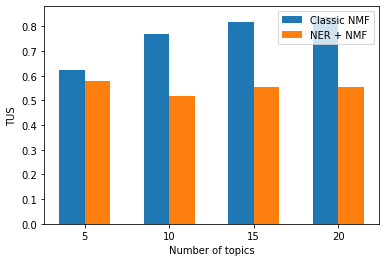

In [23]:
classic_keys = list(results['tus']['classic corpus'].keys())
extended_keys = list(results['tus']['extended corpus'].keys())

classic_values = list(results['tus']['classic corpus'].values())
extended_values = list(results['tus']['extended corpus'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

model_string = "LDA" if use_lda else "NMF"

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label=f'Classic {model_string}')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label=f'NER + {model_string}')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "TUS"

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()

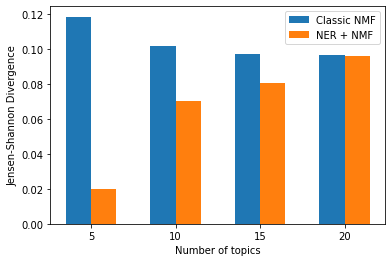

In [29]:
classic_keys = list(results['js']['classic corpus'].keys())
extended_keys = list(results['js']['extended corpus'].keys())

classic_values = list(results['js']['classic corpus'].values())
extended_values = list(results['js']['extended corpus'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

model_string = "LDA" if use_lda else "NMF"

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label=f'Classic {model_string}')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label=f'NER + {model_string}')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "Jensen-Shannon Divergence" 

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()